# Generative art experiments

[Danielle Navarro](https://art.djnavarro.net/gallery/) delivered an exceptionally captivating presentation on their generative art as part of the 2023 Ihaka lecture series. I've been enthusiastic about integrating procedural generation into my [games](https://avivajpeyi.itch.io/), as I find the concept of harnessing randomness to craft something extraordinary truly fascinating. Generative art provides a remarkable avenue for delving into this very concept. Here, I'd like to share a few of the experiments I ventured into following Danielle's enlightening talk.


## 1. Random walk

In [1]:
# import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os

def hide_axes(ax):
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.set_xticklabels([])
    ax.set_yticklabels([])


OUTDIR = "random_walk"
os.makedirs(OUTDIR, exist_ok=True)

def next_step():
    direction = np.random.uniform(-1, 1, size=1)
    distance = np.random.normal(0, 5, size=1)
    return direction * distance


def generate_random_walk(n_steps, n_smooth):
    pts = np.zeros((2, n_steps))
    for i in range(1, n_steps):
        pts[0, i] = pts[0, i-1] + next_step()
        pts[1, i] = pts[1, i-1] + next_step()
    # smooth xy coordinates
    pts[0, :] = np.convolve(pts[0, :], np.ones(n_smooth)/n_smooth, mode='same')
    pts[1, :] = np.convolve(pts[1, :], np.ones(n_smooth)/n_smooth, mode='same')
    return pts


def plot_walk(n_steps, n_walkers, seed, colormap=plt.cm.Blues_r, alpha=0.5):
    n_smooth = int(n_steps * 0.05)
    np.random.seed(seed)
    fig = plt.figure(figsize=(5,5), facecolor=(0, 0, 0))
    for i in range(n_walkers):
        pts = generate_random_walk(n_steps, n_smooth)[:, 0:n_steps-n_smooth]
        point_numbers = list(range(len(pts[0])))
        plt.scatter(pts[0, :], pts[1, :], c=point_numbers, cmap=colormap, edgecolors='none', s=1, alpha=alpha)

    plt.gca().set_facecolor('black')
    plt.axis('off')
    return fig
    
# fig = plot_walk(n_steps=5000, n_walkers=10, seed=0)
# fig.savefig(f"{OUTDIR}/1.png")
# fig = plot_walk(n_steps=5000, n_walkers=100, seed=1, colormap=plt.cm.Reds_r, alpha=0.05)
# fig.savefig(f"{OUTDIR}/2.png")
# fig = plot_walk(n_steps=100000, n_walkers=20, seed=2, colormap='winter', alpha=0.5)
# fig.savefig(f"{OUTDIR}/3.png")


|     |   |  |
|---------|---------|---------|
| ![](random_walk/1.png) | ![](random_walk/2.png) | ![](random_walk/3.png) |


## 2. N-body

### a) All bodies are the same mass

In [2]:
# Some utils
import matplotlib.pyplot as plt
# import imageio
import os
import glob
import re
from datetime import datetime
import numpy as np
from tqdm.auto import trange, tqdm
import warnings

from matplotlib import rcParams

import colorsys
from matplotlib.colors import ColorConverter, LinearSegmentedColormap

rcParams.update({"xtick.major.pad": "7.0"})
rcParams.update({"xtick.major.size": "7.5"})
rcParams.update({"xtick.major.width": "1.5"})
rcParams.update({"xtick.minor.pad": "7.0"})
rcParams.update({"xtick.minor.size": "3.5"})
rcParams.update({"xtick.minor.width": "1.0"})
rcParams.update({"ytick.major.pad": "7.0"})
rcParams.update({"ytick.major.size": "7.5"})
rcParams.update({"ytick.major.width": "1.5"})
rcParams.update({"ytick.minor.pad": "7.0"})
rcParams.update({"ytick.minor.size": "3.5"})
rcParams.update({"ytick.minor.width": "1.0"})
rcParams.update({"font.size": 20})
rcParams.update({"xtick.top": True})
rcParams.update({"ytick.right": True})
rcParams.update({"xtick.direction": "in"})
rcParams.update({"ytick.direction": "in"})


OUTDIR = 'orbit_out'
os.makedirs(OUTDIR, exist_ok=True)


def collect_runtimes(func, n_vals, n_trials=2, kwargs={}) -> np.ndarray:
    """
    Collect runtimes for a function with different input sizes

    Parameters
    ----------
    func : function
        Function to run
    n_vals : list
        List of input sizes
    n_trials : int, optional
        Number of trials to run, by default 2
    kwargs : dict, optional
        Keyword arguments to pass to func, by default {}

    Returns
    -------
    np.ndarray
        Array of runtimes with shape (len(n_vals), n_trials)
    """
    warnings.filterwarnings("error")
    runtimes = np.zeros((len(n_vals), n_trials))
    for npart_i in trange(len(n_vals), desc="Collecting runtimes"):
        for trial_i in range(n_trials):
            start = datetime.now()
            n = n_vals[npart_i]
            try:
                func(N=n, **kwargs)
                runtimes[npart_i, trial_i] = get_runtime(start)
            except RuntimeWarning:
                runtimes[npart_i, trial_i] = np.nan
    return runtimes


def get_runtime(start: datetime):
    return (datetime.now() - start).total_seconds()


def make_gif(im_regex, outname, duration=0.1):
    imgs = glob.glob(im_regex)
    imgs = sorted(imgs, key=lambda x: int(re.findall(r"\d+", x)[0]))
    frames = [imageio.imread_v2(f) for f in imgs]
    imageio.mimsave(outname, frames, duration=duration)
    for f in imgs:
        os.remove(f)


def remove_spines(ax):
    """Remove all spines and ticks from an axis"""
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_yticks([])
    ax.set_xticks([])


def scale_color_brightness(color, scale_l=1.0):
    rgb = ColorConverter.to_rgb(color)
    # convert rgb to hls
    h, l, s = colorsys.rgb_to_hls(*rgb)
    # manipulate h, l, s values and return as rgb
    return colorsys.hls_to_rgb(h, min(1, l * scale_l), s=s)


def make_colormap(color):
    rgb = [
        (i, scale_color_brightness(color, scale_l=i + 1)) for i in np.linspace(0, 1, 30)
    ]
    cmap = LinearSegmentedColormap.from_list(f"custom_{color}", colors=rgb, N=256)
    cmap = cmap.reversed()
    return cmap

from datetime import datetime
from tqdm.auto import trange
from typing import List, Union
import numpy as np
import matplotlib.pyplot as plt
import os
import random

G = 1.0  # Gravitational Constant
OUTDIR = 'orbit_out/'


def plot_particles(positions: Union[List, np.ndarray], n_time_total: int = 0, color='tab:blue'):
    """Plot the positions of particles in 2D

    Parameters
    ----------
    positions : Union[List, np.ndarray]
        List of positions of particles. Should be of shape (n_particles, {xyz}, n_time).
    n_time_total : int, optional
        Total number of time steps (used for plotting the trail), by default 0
    color : str, optional
        Color of the particles, by default 'tab:blue'
    """

    n_part, _, n_time = positions.shape
    if n_time_total == 0:
        n_time_total = n_time

    fig = plt.figure(figsize=(4, 4), dpi=80)
    ax = fig.gca()

    # plot the particle orbits
    idx_end = np.argmax(np.where(np.sum(positions, axis=(0, 1)) != 0)[0])
    idx_start = np.max([int(idx_end - 0.1 * n_time_total), 0])
    nidx = idx_end - idx_start

    max_size = 10
    ax.scatter(
        positions[:, 0, idx_end], positions[:, 1, idx_end],
        s=max_size, color=color, ec='k', lw=0.5
    )

    # plot the trail
    if nidx > 1:
        ms = np.geomspace(1e-4, max_size, nidx)
        # set ms < 0.05 to 0
        mask = ms < 0.05
        ms[mask] = 0

        # colors = np.array([make_colormap('tab:blue', 'white')(i) for i in np.linspace(0, 1, nidx)])
        ax.scatter(
            positions[:, 0, idx_start:idx_end], positions[:, 1, idx_start:idx_end],
            s=[ms] * n_part, zorder=-10,
            c=[ms] * n_part,
            cmap=make_colormap(color),

        )

    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax = plt.gca()
    remove_spines(ax)
    ax.set_aspect('equal', 'box')
    # remove white border around figure
    fig.tight_layout(pad=0)
    return fig


def plot_particle_gif(pos, outdir, dur):
    os.makedirs(outdir, exist_ok=True)
    n_part, _, n_time = pos.shape
    for i in trange(10, n_time, 10, desc='Making gif'):
        fig = plot_particles(pos[:, :, 0:i], n_time_total=n_time, color='tab:blue')
        # add textbox in top left corner
        ax = plt.gca()
        ax.text(
            0.05, 0.95,
            f't={i:003d}', transform=ax.transAxes,
            fontsize=14, verticalalignment='top',
            fontstyle='italic',
            alpha=0.5,
        )
        fig.savefig(f'{outdir}/orbit_{i:003d}.png')
        plt.close(fig)
    make_gif(f'{outdir}/orbit_*.png', f'{outdir}/orbit.gif', duration=dur)
    print(f'Gif saved to {outdir}/orbit.gif')


def newtonian_acceleration_np(pos, mass, G, softening):
    # positions r = [x,y,z] for all particles
    x = pos[:, 0:1]
    y = pos[:, 1:2]
    z = pos[:, 2:3]

    # matrix that stores all pairwise particle separations: r_j - r_i
    dx = x.T - x
    dy = y.T - y
    dz = z.T - z

    # matrix that stores 1/r^3 for all particle pairwise particle separations
    inv_r3 = (dx ** 2 + dy ** 2 + dz ** 2 + softening ** 2)
    inv_r3[inv_r3 > 0] = inv_r3[inv_r3 > 0] ** (-1.5)

    # pack together the acceleration components
    return G * np.hstack((
        np.matmul(dx * inv_r3, mass),
        np.matmul(dy * inv_r3, mass),
        np.matmul(dz * inv_r3, mass)
    ))


def nbody_runner_np(
        N: int = 5,
        tEnd: float = 10.0,
        dt: float = 0.01,
        softening: float = 0.1,
        random_seed: int = 17,
        max_runtime: int = 5,
        verbose: bool = True,
):
    """ N-body simulation """

    # Initialisation
    np.random.seed(random_seed)
    mass = 20.0 * np.ones((N, 1)) / N  # total mass of particles is 20
    pos = np.random.randn(N, 3)  # randomly selected positions and velocities
    vel = np.random.randn(N, 3)
    t = 0
    Nt = int(np.ceil(tEnd / dt))
    runtime_start = datetime.now()
    vel -= np.mean(mass * vel, 0) / np.mean(mass)
    acc = newtonian_acceleration_np(pos, mass, G, softening)
    pos_save = np.zeros((N, 3, Nt + 1))
    pos_save[:, :, 0] = pos

    # Simulation loop
    for i in trange(Nt, desc="Running simulation", disable=not verbose):
        vel += acc * dt / 2.0
        pos += vel * dt
        acc = newtonian_acceleration_np(pos, mass, G, softening)
        vel += acc * dt / 2.0
        t += dt
        pos_save[:, :, i + 1] = pos
        runtime = get_runtime(runtime_start)
        if runtime > max_runtime:
            warnings.warn(f"Runtime exceeded {max_runtime} seconds. Stopping simulation.")
            break
    return pos_save




import matplotlib.collections as mcoll

def colorline(
    x, y, z=None, cmap=plt.get_cmap('copper'), norm=plt.Normalize(0.0, 1.0),
        linewidth=3, alpha=1.0):
    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])

    z = np.asarray(z)

    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                              linewidth=linewidth, alpha=alpha)

    ax = plt.gca()
    ax.add_collection(lc)

    return lc


def make_segments(x, y):
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments



def plot_simple_orbits(seed, N=2, tEnd=3, dt=0.001, spacing=0.001, nlin=30):
    fig = plt.figure(figsize=(10,10), facecolor='black')
    positions = nbody_runner_np(N=N, random_seed=seed, tEnd=tEnd, verbose=False, dt=dt)

    max_lim_x, min_lim_x = np.max(positions[:, 0, :]), np.min(positions[:, 0, :])
    max_lim_y, min_lim_y = np.max(positions[:, 1, :]), np.min(positions[:, 1, :])

    pts = np.linspace(0, 1, positions.shape[2])
    
    plt.xlim(min_lim_x, max_lim_x)
    plt.ylim(min_lim_y, max_lim_y)
    for i, plnts in enumerate(positions):
        # decrease alpha over time
        # alpha = np.linspace(0.1, 1, len(i))
        # color between white and blue
        colorbar = make_colormap(f'C{i}')

#         colorline(plnts[0][1:-1], plnts[1][1:-1], pts, cmap=colorbar, linewidth=2)

        for _ in reversed(range(nlin)):
            colorline(plnts[0][1:-1]+spacing*_, plnts[1][1:-1]+spacing*_, pts, cmap=colorbar, linewidth=2*0.1*_, alpha=0.01*_)

    # turn off axis
#     plt.suptitle(seed, color='white')
    plt.xlim(min_lim_x, max_lim_x)
    plt.ylim(min_lim_y, max_lim_y)
    plt.axis('off')
    # get max x
    # get max y
    # recompute the ax.dataLim
    plt.axis('auto')
    plt.box(False)
    plt.gca().set_facecolor('black')
    plt.tight_layout()
    return fig

# 

# plot_simple_orbits(91)
# plot_particle_gif(positions, outdir=f'orbits.gif', dur=3)

# for i in range(10):
#     fig = plot_simple_orbits(i,spacing=0.005, nlin=50)
#     fig.savefig(f"{OUTDIR}/2body_{i:002d}.png" )
#     plt.close(fig)
# for i in range(200,250):
#     fig = plot_simple_orbits(i, N=3,spacing=0.005)
#     fig.savefig(f"{OUTDIR}/3body_{i:002d}.png")
#     plt.close(fig)

|  |  |
|---------|---------|
| ![](orbit_out/2body_00.png) | ![](orbit_out/2body_7.png) |
| ![](orbit_out/3body_16.png) | ![](orbit_out/3body_32.png) |
| ![](orbit_out/3body_54.png) | ![](orbit_out/3body_202.png) |
| ![](orbit_out/3body_210.png) | ![](orbit_out/3body_227.png) |

![](orbits.gif/orbit.gif)

### b) One central 'black hole'

In [80]:
MIN_V, MAX_V  = 3,7

## 2 Body newtonian gravity, 1 body fixed in the center
def twobody_runner_np(
        N: int = 5,
        tEnd: float = 10.0,
        dt: float = 0.01,
        softening: float = 0.1,
        random_seed: int = 17,
        max_runtime: int = 5,
        verbose: bool = True,
):
    """ N-body simulation """

    # Initialisation
    np.random.seed(random_seed)
    
    
    # First body (mass = 100, velocity = [0, 0, 0], position = [0, 0, 0])
    mass = np.array([np.concatenate((np.array([100.0]), 0.1 * np.ones(N - 1)))]).T  # First body has 100 times the mass
    pos = np.zeros((N, 3))  # All positions along the Z axis are 0
    vel = np.zeros((N, 3))  # All velocities along the Z axis are 0
    t = 0
    Nt = int(np.ceil(tEnd / dt))
    runtime_start = datetime.now()
    
    # Calculate tangential velocity for other bodies
    angular_velocity = np.sqrt(G * mass[0] / 10)  # Tangential velocity formula
    for i in range(1, N):
        R = np.random.uniform(1.5,3)
        theta = np.random.uniform(0, 2*np.pi)
        pos[i, 0] =  np.sin(theta) * R
        pos[i, 1] = np.cos(theta) * R

        
        theta = np.arctan2(pos[i, 1], pos[i, 0])  # Angle relative to x-axis
        # print(theta)
        vel_magnitude = np.random.uniform(MIN_V, MAX_V) # Tangential velocity magnitude
        vel[i, 0] = -vel_magnitude * np.sin(theta)  # Tangential velocity components
        vel[i, 1] = vel_magnitude * np.cos(theta)


    acc = newtonian_acceleration_np(pos, mass, G, softening)
    pos_save = np.zeros((N, 3, Nt + 1))
    pos_save[:, :, 0] = pos

    # Simulation loop
    for i in trange(Nt, desc="Running simulation", disable=not verbose):
        vel += acc * dt / 2.0
        pos += vel * dt
        acc = newtonian_acceleration_np(pos, mass, G, softening)
        vel += acc * dt / 2.0
        t += dt
        pos_save[:, :, i + 1] = pos
        runtime = get_runtime(runtime_start)
        if runtime > max_runtime:
            warnings.warn(f"Runtime exceeded {max_runtime} seconds. Stopping simulation.")
            break

    for j in range(1, N):
        if np.linalg.norm(pos[j]) > 0. :
            pos[j] = np.array([np.nan, np.nan, np.nan])
 
    return pos_save



def plot_2body_orbits(seed, N=2, tEnd=3, dt=0.001, spacing=0.001, nlin=30, alpha_rev=False):
    fig = plt.figure(figsize=(10,10), facecolor='black')
    positions = twobody_runner_np(N=N, random_seed=seed, tEnd=tEnd, verbose=False, dt=dt)


    
    max_lim_x, min_lim_x = np.max(positions[:, 0, :]), np.min(positions[:, 0, :])
    max_lim_y, min_lim_y = np.max(positions[:, 1, :]), np.min(positions[:, 1, :])

    pts = np.linspace(0, 1, positions.shape[2])
    
    plt.xlim(min_lim_x, max_lim_x)
    plt.ylim(min_lim_y, max_lim_y)
    for i, plnts in enumerate(positions):
        if i ==0 :
            continue
        # decrease alpha over time
        # alpha = np.linspace(0.1, 1, len(i))
        # color between white and blue
        colorbar = make_colormap(f'C{i}')

#         colorline(plnts[0][1:-1], plnts[1][1:-1], pts, cmap=colorbar, linewidth=2)

        for _ in range(nlin):
            a = 0.01*_
            if alpha_rev:
                a = 1 - a
            colorline(plnts[0][1:-1]+spacing*_, plnts[1][1:-1]+spacing*_, pts, cmap=colorbar, linewidth=2*0.1*_, alpha=a)

    # turn off axis
#     plt.suptitle(seed, color='white')
    plt.xlim(min_lim_x, max_lim_x)
    plt.ylim(min_lim_y, max_lim_y)
    plt.axis('off')
    # get max x
    # get max y
    # recompute the ax.dataLim
    plt.axis('auto')
    plt.box(False)
    plt.gca().set_facecolor('black')
    plt.tight_layout()
    return fig


# OUTDIR = 'black_hole' 
# os.makedirs(OUTDIR, exist_ok=True)
# fig = plot_2body_orbits(1, N=2, tEnd=15, spacing=0.01)
# fig.savefig(f"{OUTDIR}/1.png")
# MIN_V, MAX_V  = 6,10
# fig = plot_2body_orbits(5, N=2, tEnd=50, spacing=0.5, dt=0.01, nlin=6, alpha_rev=True)
# fig.savefig(f"{OUTDIR}/2.png")
# fig = plot_2body_orbits(21, N=2, tEnd=50, spacing=0.1, dt=0.1, nlin=6, alpha_rev=True)
# fig.savefig(f"{OUTDIR}/3.png")

|  |  | |
|---------|---------|---------|
| ![](black_hole/1.png) | ![](black_hole/2.png) | ![](black_hole/3.png) |

## 3. Math functions

DEPRECATION: devscripts 2.20.2ubuntu2 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of devscripts or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


/tmp/ipykernel_182490/1897044965.py:44: RuntimeWarning: invalid value encountered in sqrt
  result = random.uniform(-0.5,0.5) * y**3 - np.cos(x**2) + np.sqrt(2*x)


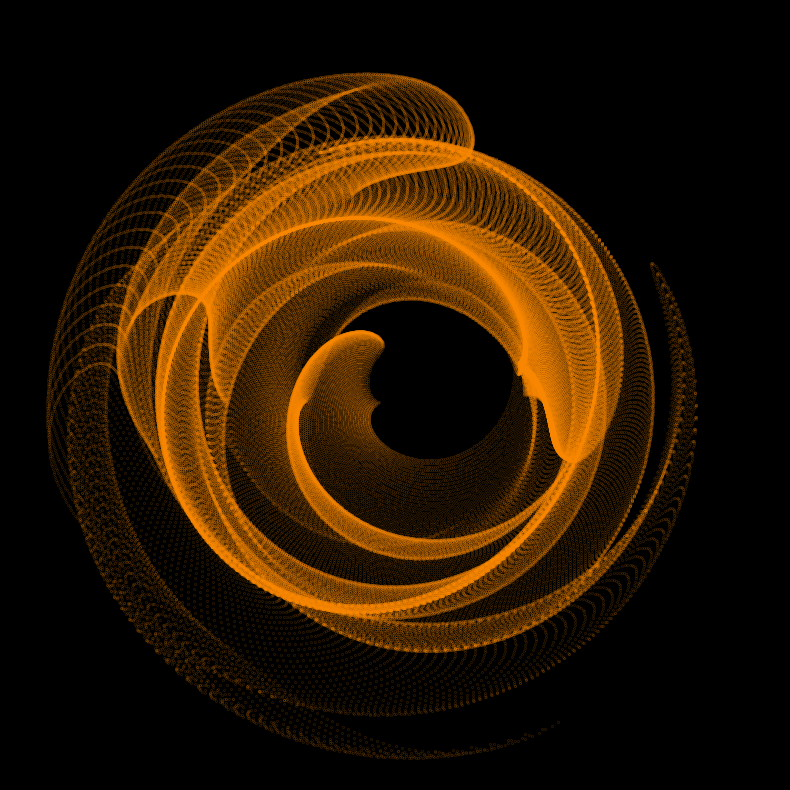

In [2]:
! pip install samila==1.1 -q

import matplotlib.pyplot as plt
import random
from samila import GenerativeImage, Projection, Marker
from samila import Projection



# import numpy as np
# import matplotlib.pyplot as plt

# # Create a grid of x and y values
# x = np.linspace(-2, 2, 400)
# y = np.linspace(-2, 2, 400)
# X, Y = np.meshgrid(x, y)

# # Calculate the function values for each point on the grid
# result = np.random.uniform(-1, 1, size=X.shape) * X**2 - np.sin(Y**2) + np.abs(Y - X)

# # Create a contour plot
# plt.contourf(X, Y, result, levels=20, cmap='viridis')
# plt.colorbar()

# # Add labels and a title
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('Contour Plot of the Function')

# # Show the plot
# plt.show()


OUTDIR = '3d_fx' 
os.makedirs(OUTDIR, exist_ok=True)

np.random.seed(0)

def f1(x, y):
    result = random.uniform(-1,1) * x**2  - np.sin(y**2) + np.abs(y-x)
    return result

def f2(x, y):
    result = random.uniform(-0.5,0.5) * y**3 - np.cos(x**2) + np.sqrt(2*x)
    return result

def f3(x, y):
    result = random.uniform(-1,1) * x*y + np.tan(x*y)
    return result

def f4(x,y, b=.1, a=0.3,c=0.3,d=.4):
    return (np.sqrt((np.sqrt((x*np.sin(b) + a*np.cos(b))**2))))

g2 = GenerativeImage(f2, f1)
g2.generate(seed=5)
# g2.plot(cmap="winter", color="darkorange", alpha=0.5, bgcolor="black",)
# plt.savefig(f"{OUTDIR}/1.png")
g2.plot(cmap="winter", color="darkorange", projection=Projection.POLAR, marker=Marker.CIRCLE,alpha=1,bgcolor="black")
plt.savefig(f"{OUTDIR}/2_highres.png", dpi=300)
# g2 = GenerativeImage(f4, f1)
# g2.generate(seed=5)
# g2.plot(cmap="winter", color="darkorange", alpha=0.5, bgcolor="black",)
# plt.savefig(f"{OUTDIR}/3.png")

|   |   |  |
|---------|---------|---------|
| ![](3d_fx/1.png) | ![](3d_fx/2.png) | ![](3d_fx/3.png) |



:::{admonition} Update Oct 25, 2023
:class: dropdown

The middle panel image won a small generative art contest for the Ihaka lecture series!
:::


